In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, GRU, Dense, Conv1D
from keras.callbacks import ModelCheckpoint

In [3]:
data = pd.read_csv("webtraffic.csv")

In [4]:
data.shape


(4896, 2)

In [5]:
data.head()


,Hour Index,Sessions
0,0,1418159421
1,1,1113769116
2,2,919158921
3,3,822352824
4,4,735526737


In [6]:
sessions = data['Sessions'].values


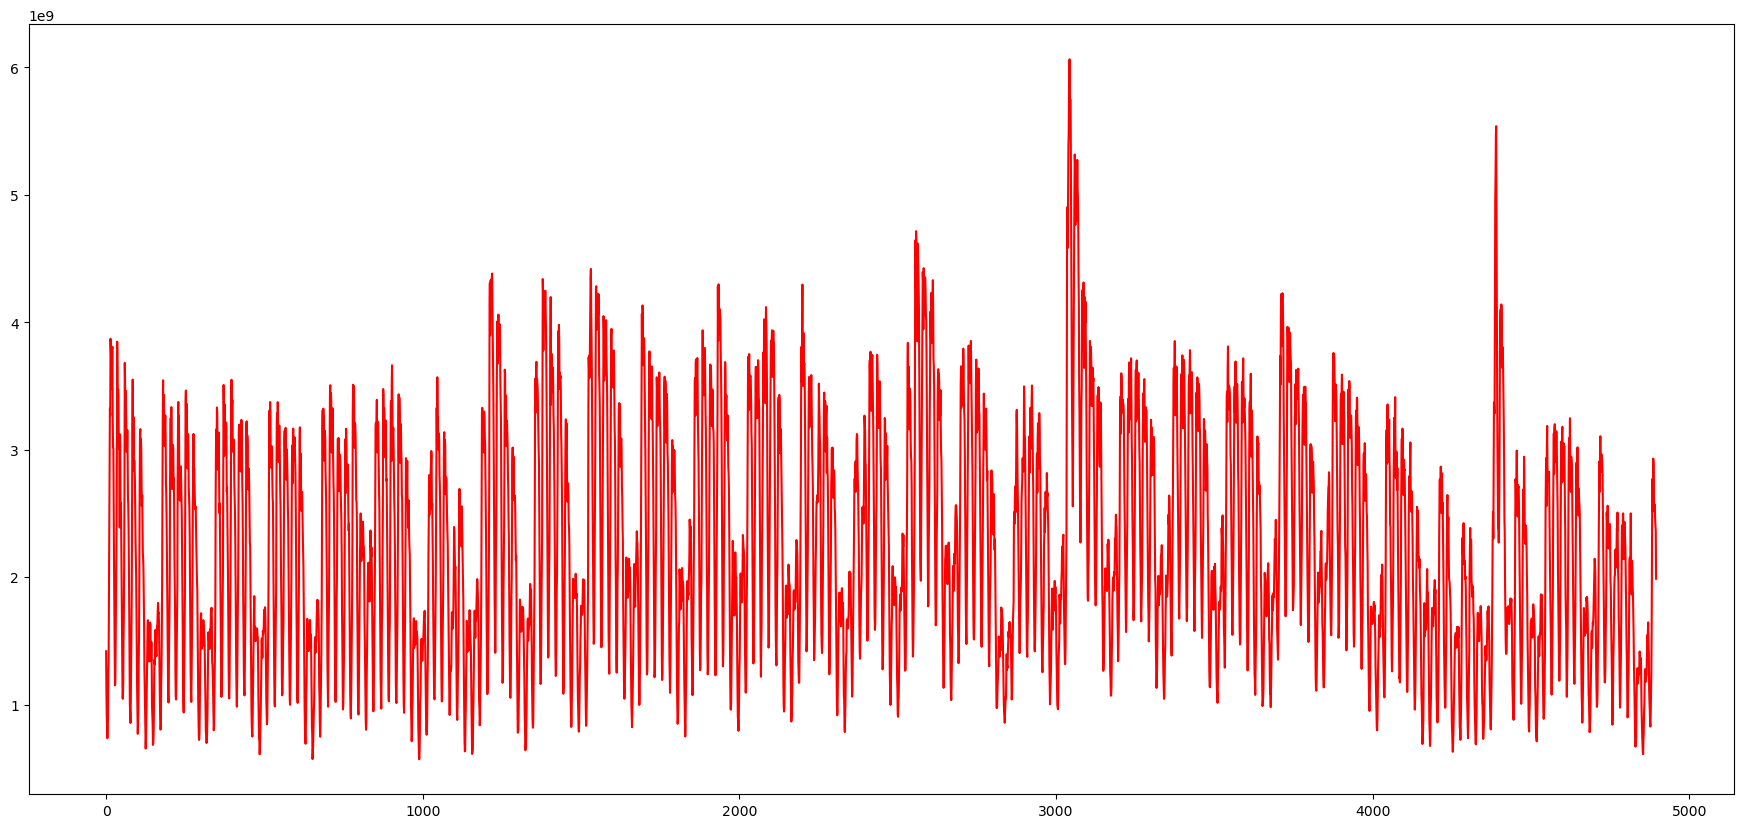

In [7]:
ar = np.arange(len(sessions))
plt.figure(figsize = (22,10))
plt.plot(ar, sessions, 'r')
plt.show()

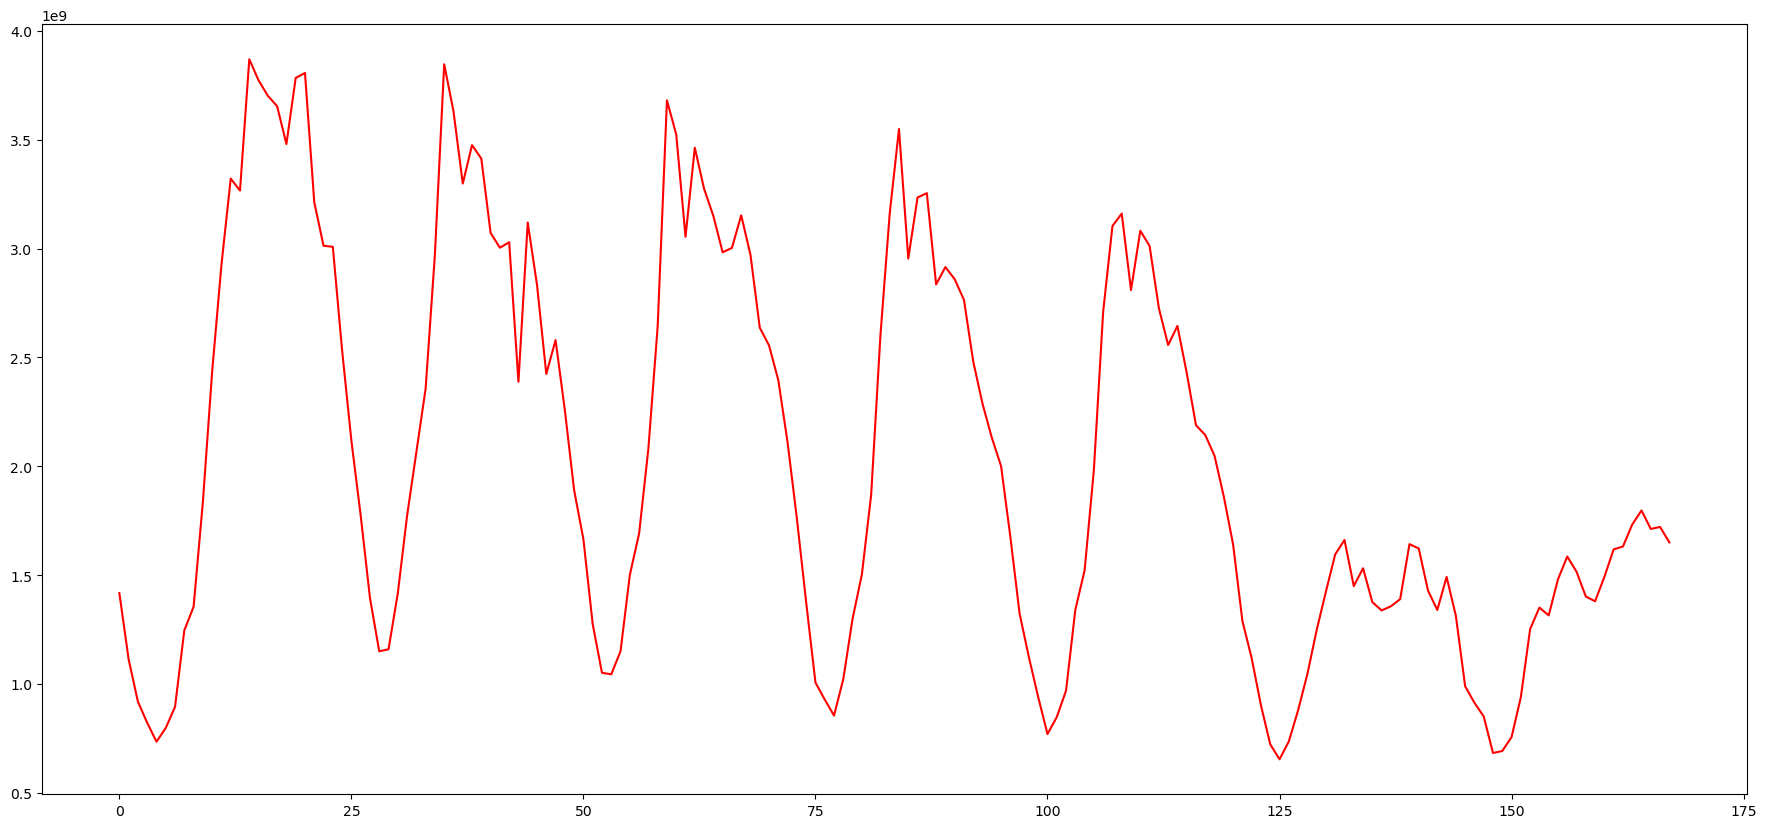

In [8]:
sample = sessions[:168]
ar = np.arange(len(sample))
plt.figure(figsize = (22,10))
plt.plot(ar, sample, 'r')
plt.show()

In [9]:
def prepare_data(seq, num):
    x = []
    y = []
    for i in range(0, (len(seq)- num), 1):
        input_ = seq[i:i+num]
        output = seq[i+num]
        
        x.append(input_)
        y.append(output)
    
    return np.array(x), np.array(y)

In [10]:
num = 168
x,y = prepare_data(sessions, num)
print(len(x))

4728


In [11]:
ind = int(0.9*len(x))

# prepare training and test data
X_train = x[:ind]
y_train = y[:ind]

X_test = x[ind:]
y_test = y[ind:]

In [12]:
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.fit_transform(X_test)

In [13]:
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

In [14]:
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)[:, 0]
y_test = y_scaler.fit_transform(y_test)[:, 0]

In [15]:
X_train= X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test= X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print(X_train.shape)

(4255, 168, 1)


In [16]:
model = Sequential()
model.add(LSTM(128, input_shape = (168,1)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss = 'mse', optimizer = 'adam')
mc = ModelCheckpoint('best_model.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = True, mode = min)
# train the model

history = model.fit(X_train, y_train, epochs = 30, batch_size = 32,
                   validation_data = (X_test, y_test), callbacks = [mc])

Epoch 1/30
133/133 [==============================] - ETA: 0s - loss: 0.1634
Epoch 1: val_loss improved from inf to 0.04902, saving model to best_model.hdf5
133/133 [==============================] - 13s 85ms/step - loss: 0.1634 - val_loss: 0.0490
Epoch 2/30
133/133 [==============================] - ETA: 0s - loss: 0.0366
Epoch 2: val_loss improved from 0.04902 to 0.04877, saving model to best_model.hdf5
133/133 [==============================] - 13s 95ms/step - loss: 0.0366 - val_loss: 0.0488
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 0.0338
Epoch 3: val_loss improved from 0.04877 to 0.03883, saving model to best_model.hdf5
133/133 [==============================] - 14s 104ms/step - loss: 0.0338 - val_loss: 0.0388
Epoch 4/30
133/133 [==============================] - ETA: 0s - loss: 0.0332
Epoch 4: val_loss did not improve from 0.03883
133/133 [==============================] - 12s 94ms/step - loss: 0.0332 - val_loss: 0.0428
Epoch 5/30
133/133 [============

In [20]:
model.load_weights('best_model.hdf5')

In [22]:
mse = model.evaluate(X_train, y_train)
print("Mean Square Error:",mse)

133/133 [==============================] - 4s 31ms/step - loss: 0.0165
Mean Square Error: 0.016472933813929558


In [23]:
def Forecast(X_test, no_of_pred, ind):
    predictions = []
    temp = X_test[ind]
    for i in range(no_of_pred):
        pred = model.predict(temp.reshape(1,-1,1))[0][0]
        temp = np.insert(temp, len(temp), pred)
        predictions.append(pred)
        temp = temp[1:]
    return predictions

In [24]:
no_of_pred = 24
ind = 72
y_pred = Forecast(X_test, no_of_pred, ind)
y_true = y_test[ind:ind+(no_of_pred)]

1/1 [==============================] - 0s 40ms/step


In [25]:
def plot(y_true,y_pred):
  ar = np.arange(len(y_true))
  plt.figure(figsize=(22,10))
  plt.plot(ar, y_true,'r')
  plt.plot(ar, y_pred,'y')
  plt.show()

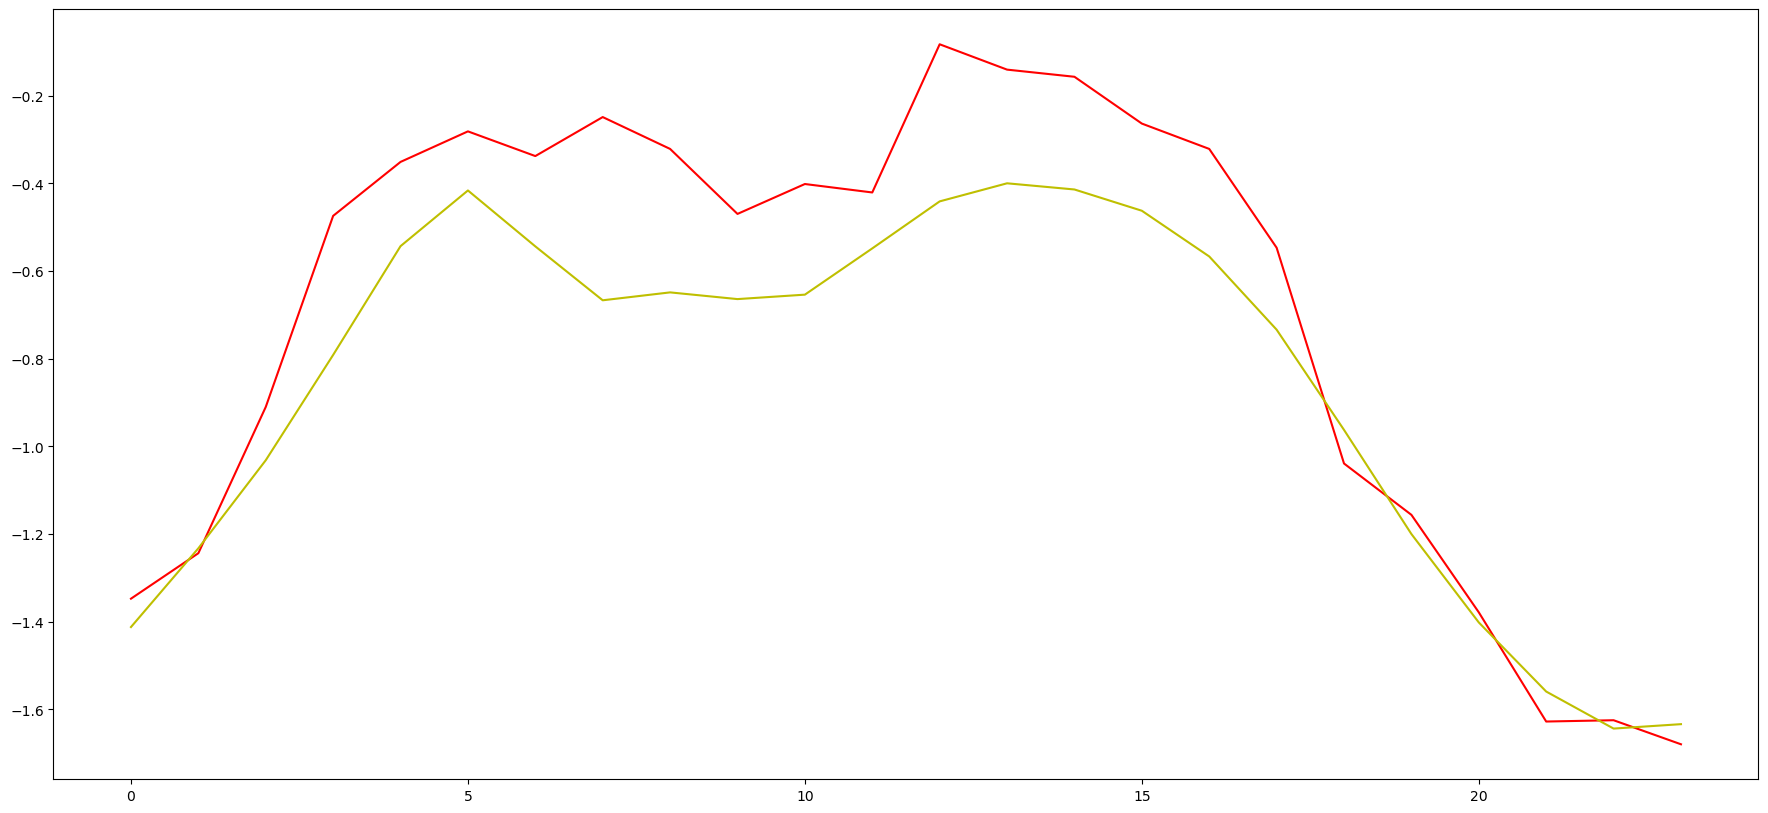

In [26]:
plot(y_true, y_pred)

In [29]:
# Create and compile the Simple RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(128, input_shape=(168, 1)))
model_rnn.add(Dense(64, activation='relu'))
model_rnn.add(Dense(1, activation='linear'))
model_rnn.compile(loss='mse', optimizer='adam')

In [30]:
# Train the Simple RNN model
history_rnn = model_rnn.fit(X_train, y_train, epochs=30, batch_size=32,
                            validation_data=(X_test, y_test), callbacks=[mc])

model_rnn.load_weights('best_model.hdf5')

Epoch 1/30
131/133 [============================>.] - ETA: 0s - loss: 0.0615
Epoch 1: val_loss did not improve from 0.02497
133/133 [==============================] - 4s 25ms/step - loss: 0.0610 - val_loss: 0.0314
Epoch 2/30
131/133 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 2: val_loss did not improve from 0.02497
133/133 [==============================] - 3s 25ms/step - loss: 0.0228 - val_loss: 0.0270
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 0.0202
Epoch 3: val_loss improved from 0.02497 to 0.02235, saving model to best_model.hdf5
133/133 [==============================] - 3s 25ms/step - loss: 0.0202 - val_loss: 0.0223
Epoch 4/30
131/133 [============================>.] - ETA: 0s - loss: 0.0189
Epoch 4: val_loss improved from 0.02235 to 0.02091, saving model to best_model.hdf5
133/133 [==============================] - 3s 26ms/step - loss: 0.0189 - val_loss: 0.0209
Epoch 5/30
132/133 [============================>.] - ETA: 0s - loss: 

In [33]:
# Create and compile the GRU model
model_gru = Sequential()
model_gru.add(GRU(128, input_shape=(168, 1)))  # Add the missing closing parenthesis here
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dense(1, activation='linear'))
model_gru.compile(loss='mse', optimizer='adam')


In [34]:
# Train the GRU model
history_gru = model_gru.fit(X_train, y_train, epochs=30, batch_size=32,
                          validation_data=(X_test, y_test), callbacks=[mc])

model_gru.load_weights('best_model.hdf5')

Epoch 1/30
133/133 [==============================] - ETA: 0s - loss: 0.1218
Epoch 1: val_loss did not improve from 0.01795
133/133 [==============================] - 12s 81ms/step - loss: 0.1218 - val_loss: 0.0572
Epoch 2/30
133/133 [==============================] - ETA: 0s - loss: 0.0445
Epoch 2: val_loss did not improve from 0.01795
133/133 [==============================] - 12s 87ms/step - loss: 0.0445 - val_loss: 0.0477
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 0.0381
Epoch 3: val_loss did not improve from 0.01795
133/133 [==============================] - 12s 91ms/step - loss: 0.0381 - val_loss: 0.0429
Epoch 4/30
133/133 [==============================] - ETA: 0s - loss: 0.0350
Epoch 4: val_loss did not improve from 0.01795
133/133 [==============================] - 12s 90ms/step - loss: 0.0350 - val_loss: 0.0459
Epoch 5/30
133/133 [==============================] - ETA: 0s - loss: 0.0330
Epoch 5: val_loss did not improve from 0.01795
133/133 [=======

ValueError: Invalid bias shape: (128,)

In [35]:
# Create and compile the Conv1D model
model_conv1d = Sequential()
model_conv1d.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(168, 1)))
model_conv1d.add(Flatten())
model_conv1d.add(Dense(64, activation='relu'))
model_conv1d.add(Dense(1, activation='linear'))
model_conv1d.compile(loss='mse', optimizer='adam')

In [36]:
# Train the Conv1D model
history_conv1d = model_conv1d.fit(X_train, y_train, epochs=30, batch_size=32,
                                  validation_data=(X_test, y_test), callbacks=[mc])

model_conv1d.load_weights('best_model.hdf5')

Epoch 1/30
132/133 [============================>.] - ETA: 0s - loss: 0.1328
Epoch 1: val_loss did not improve from 0.01795
133/133 [==============================] - 3s 21ms/step - loss: 0.1327 - val_loss: 0.0935
Epoch 2/30
132/133 [============================>.] - ETA: 0s - loss: 0.0366
Epoch 2: val_loss did not improve from 0.01795
133/133 [==============================] - 3s 19ms/step - loss: 0.0367 - val_loss: 0.0716
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 0.0261
Epoch 3: val_loss did not improve from 0.01795
133/133 [==============================] - 3s 20ms/step - loss: 0.0261 - val_loss: 0.0550
Epoch 4/30
133/133 [==============================] - ETA: 0s - loss: 0.0233
Epoch 4: val_loss did not improve from 0.01795
133/133 [==============================] - 3s 21ms/step - loss: 0.0233 - val_loss: 0.0518
Epoch 5/30
133/133 [==============================] - ETA: 0s - loss: 0.0192
Epoch 5: val_loss did not improve from 0.01795
133/133 [===========

ValueError: axes don't match array

In [37]:
def forecast(model, X_test, no_of_pred, ind):
    predictions = []
    temp = X_test[ind]
    for i in range(no_of_pred):
        pred = model.predict(temp.reshape(1, -1, 1))[0][0]
        temp = np.insert(temp, len(temp), pred)
        predictions.append(pred)
        temp = temp[1:]
    return predictions

In [38]:
y_pred_lstm = forecast(model, X_test, no_of_pred, ind)
y_pred_rnn = forecast(model_rnn, X_test, no_of_pred, ind)
y_pred_gru = forecast(model_gru, X_test, no_of_pred, ind)
y_pred_conv1d = forecast(model_conv1d, X_test, no_of_pred, ind)

1/1 [==============================] - 0s 30ms/step


In [39]:
def plot_comparison(y_true, y_pred_lstm, y_pred_rnn, y_pred_gru, y_pred_conv1d):
    ar = np.arange(len(y_true))
    plt.figure(figsize=(22, 10))
    plt.plot(ar, y_true, 'r', label="True")
    plt.plot(ar, y_pred_lstm, 'y', label="LSTM")
    plt.plot(ar, y_pred_rnn, 'g', label="Simple RNN")
    plt.plot(ar, y_pred_gru, 'b', label="GRU")
    plt.plot(ar, y_pred_conv1d, 'c', label="Conv1D")
    plt.legend()
    plt.show()

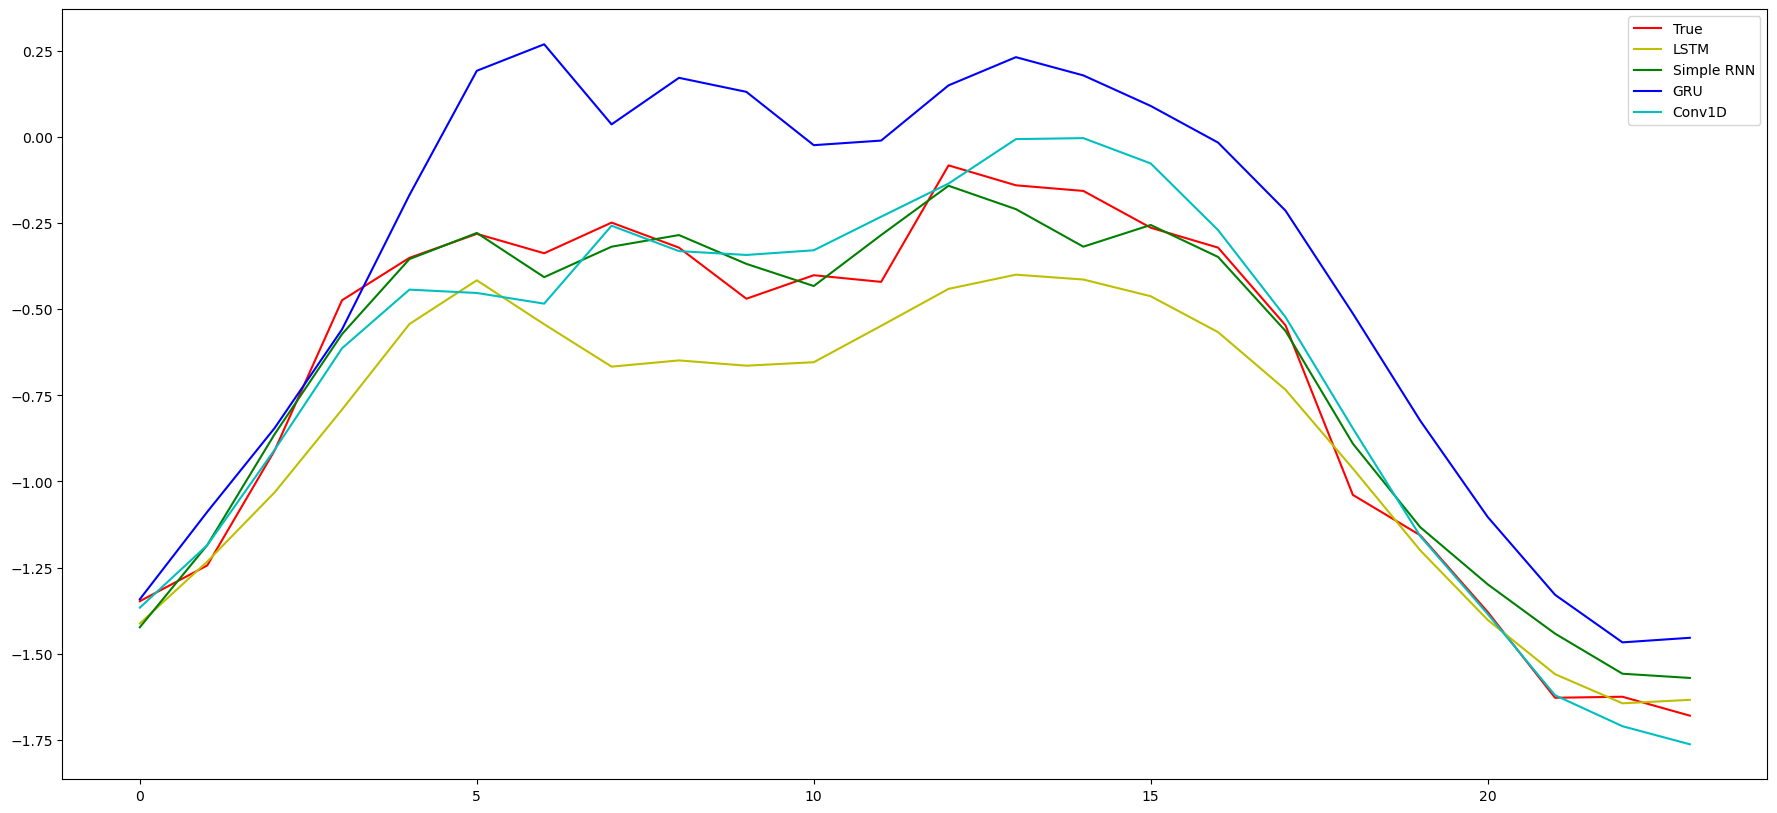

In [40]:
plot_comparison(y_true, y_pred_lstm, y_pred_rnn, y_pred_gru, y_pred_conv1d)